In [ ]:
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline

shell_scripts_template = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""
nodes = 1; gpus=6

test_run = 1
test_run = bool(test_run)


model_name = 'llama-7b'; model_name_or_path = '../results/baselines/huggyllama/llama-7b'
# model_name = 'llama-7b_ft=hmv1'; model_name_or_path = '../results/ft1/llama-7b_humanmix'

save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}"
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

# datasets = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']; nodes = 1; gpus=6; cpu_mem = 512
# datasets = ['tulu_v1_human_mix', 'tulu_v2_human_mix']; nodes = 1; gpus=1; cpu_mem = 64
# datasets = ['flan_v2']; nodes = 1; gpus=6; cpu_mem = 512
datasets = ['flan2022_1m']; nodes = 2; gpus=6; cpu_mem = 512

## for testing
# datasets = ['lima']; nodes = 1; gpus=2; cpu_mem = 512



for dataset in datasets:
    cmd = f"""
    torchrun --nnodes={nodes} --nproc_per_node={gpus} \
        --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT \
        note_llama_embeddings.py \
        --dataset {dataset} \
        --model_name_or_path {model_name_or_path} \
        --save_dir {save_dir} \
        --use_dist \
        --shuffle
    """
    cmd = multiline_to_singleline(cmd)

    shell_scripts = shell_scripts_template.format(
        cmd=cmd, log_dir=log_dir, save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'LM_outputs.{dataset}', 
        nodes=nodes,
        num_cpus=32,
        cpu_mem=cpu_mem,
        num_gpus=gpus,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    print(cmd)
    if not test_run:
        print(out)

In [ ]:
p = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/llama-7b/lima.pkl'
with open(p, 'rb') as f:
    x = pickle.load(f)
x

In [ ]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
ax.plot(np.exp(x['log_probs']), label='probs')
ax.plot(x['el2ns'], label='el2n')
ax.legend()

ax = axs[1]
ax.scatter(np.exp(x['log_probs']), x['el2ns'])
ax.set_xlabel('prob')
ax.set_ylabel('el2n')


In [ ]:
import os

processed_dir = '../data/processed'
datasets = []
for dataset in os.listdir(processed_dir) + ['tulu_v1_human_mix', 'tulu_v2_human_mix']:
    dataset_path = os.path.join(processed_dir, dataset)
    save_path = os.path.join(save_dir, f'{dataset}.pkl')
    if 'tulu'==dataset:
        continue
    if 'tulu' not in dataset and not os.path.isdir(dataset_path):
        continue
    if os.path.isfile(save_path):
        continue
    datasets.append(dataset)
    
datasets
    

In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#     os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


Fri Oct  6 21:46:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000035:04:00.0 Off |                    0 |
| N/A   32C    P0    38W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000035:05:00.0 Off |                    0 |
| N/A   

In [2]:
from collections import defaultdict
from functools import partial
import os
import numpy as np
import time
import random
import pickle
from tqdm import tqdm 

import pyarrow # import before `torch`, `transformers`, `datasets`
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset

from transformers import AutoModelForCausalLM, AutoTokenizer

from open_instruct.finetune_trainer import encode_with_prompt_completion_format, encode_with_messages_format
from note_llama_embeddings import combine_lm_outputs_for_mixes, datasets_shard_chunk_size, compute_losses


[2023-10-06 21:46:54,901] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
test_run = True
shuffle = False

model_name = 'llama-7b'; model_name_or_path = '../results/baselines/huggyllama/llama-7b'
model_name = 'pythia-1.4b'; model_name_or_path = '../results/baselines/EleutherAI/pythia-1.4b'
model_name = 'pythia-160m-deduped'; model_name_or_path = 'EleutherAI/pythia-160m-deduped'


save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}"
if not test_run:
    os.makedirs(save_dir, exist_ok=True)

In [54]:
dataset = 'lima'
dataset = 'flan_v2'

use_dist = False
shuffle = True


if dataset in ['tulu_v1_human_mix', 'tulu_v2_human_mix']:
    combine_lm_outputs_for_mixes(dataset, save_dir)


if use_dist:
    dist.init_process_group("gloo", timeout=datetime.timedelta(hours=6))
    world_size = dist.get_world_size()
    rank = dist.get_rank() # global rank
    local_rank = int(os.environ["LOCAL_RANK"])
else:
    rank = 0
    local_rank = 0
    world_size = 1

print(f'rank/local_rank/world_size: {rank}/{local_rank}/{world_size}\n')

device = f'cuda:{str(local_rank)}'


rank/local_rank/world_size: 0/0/1



In [5]:
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map=device,
    torch_dtype=torch.float16)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

Using pad_token, but it is not set yet.


In [55]:
processed_dir = '../data/processed'
if 'flan2022' in dataset:
    train_file = os.path.join(processed_dir, 'flan2022', f'{dataset}_data.jsonl')
else:
    train_file = os.path.join(processed_dir, dataset, f'{dataset}_data.jsonl')
assert(os.path.isfile(train_file))


encode_function = partial(
    encode_with_messages_format, tokenizer=tokenizer, max_seq_length=2048)

if rank == 0:
    raw_datasets = load_dataset("json", data_files={'train': train_file})
    if test_run:
        raw_datasets['train'] = raw_datasets['train'].select(range(1000))
    print(f"{dataset} dataset length = {len(raw_datasets['train'])}")
    lm_datasets = raw_datasets.map(
        encode_function, batched=False, num_proc=16,
        desc="Tokenizing and reformatting instruction data")
if use_dist:
    dist.barrier()
if rank!= 0:
    raw_datasets = load_dataset("json", data_files={'train': train_file})
    if test_run:
        raw_datasets['train'] = raw_datasets['train'].select(range(1000))
    print(f"{dataset} dataset length = {len(raw_datasets['train'])}")
    lm_datasets = raw_datasets.map(
        encode_function, batched=False, num_proc=16,
        desc="Tokenizing and reformatting instruction data")

    

train_dataset = lm_datasets['train']
train_dataset.set_format(
    type="torch",
    output_all_columns=False,
    columns=['input_ids', 'labels', 'attention_mask'])
if shuffle:
    random.seed(0)
    shuffle_inds = list(range(len(train_dataset)))
    random.shuffle(shuffle_inds)
    reverse_shuffle_inds = [(i, ind) for i, ind in enumerate(shuffle_inds)]
    reverse_shuffle_inds = sorted(reverse_shuffle_inds, key=lambda x: x[1])
    reverse_shuffle_inds = [x[0] for x in reverse_shuffle_inds]
    train_dataset = train_dataset.select(shuffle_inds)
train_dataset_chunk_sizes = [datasets_shard_chunk_size(len(train_dataset), num_shards=world_size, index=i) 
            for i in range(world_size)]
train_dataset = train_dataset.shard(
    num_shards=world_size, 
    index=rank,
    contiguous=True)
loader = DataLoader(train_dataset, shuffle=False, batch_size=1, pin_memory=True) 

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-486fcbba36f2e93b/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

flan_v2 dataset length = 1000


Tokenizing and reformatting instruction data (num_proc=16):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [56]:
i = 0

output = defaultdict(list)
for batch in tqdm(loader, disable=rank!=0, total=len(loader)):
    batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
    # with torch.inference_mode():
    outputs = model(**batch, output_hidden_states=True)

    # (bsz, seq_len, hidden_size) -> (bsz, hidden_size)
    text_embedding = outputs['hidden_states'][-1].mean(1)
    # average of output token log probs
    log_prob = -outputs['loss']
    # compute EL2N score
    losses = compute_losses(outputs['logits'], batch['labels'])

    output['text_embedding'].append(text_embedding.detach().cpu().to(torch.float32))
    output['log_prob'].append(log_prob.detach().cpu())
    for k in ['el2n_agg=mean', 'el2n_agg=l2n', 'logit_margin']:
        output[k].append(losses[k].detach().cpu())

    
    model.zero_grad()
    outputs['loss'].backward()
    

    grads = []
    for param_name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            grads.append(param.grad.squeeze())
    grads = [x.reshape(-1,1) for x in grads]
    grads = torch.vstack(grads)
    grad_norm = torch.sum(grads*grads).detach().cpu()
    output['grad_norm'].append(grad_norm)
    # print(f'grad_norm = {grad_norm:.2f}')
    
    
    i += 1
#     if i == 300:
#         break
        
    
for k, v in output.items():
    output[k] = torch.vstack(v).to(torch.float32).numpy()
    

print(f'[local_rank/global={local_rank}/{rank}] '
      f'output={[(k, v.shape) for k, v in output.items()]}')

100%|██████████| 1000/1000 [01:07<00:00, 14.88it/s]


[local_rank/global=0/0] output=[('text_embedding', (1000, 768)), ('log_prob', (1000, 1)), ('el2n_agg=mean', (1000, 1)), ('el2n_agg=l2n', (1000, 1)), ('logit_margin', (1000, 1)), ('grad_norm', (1000, 1))]


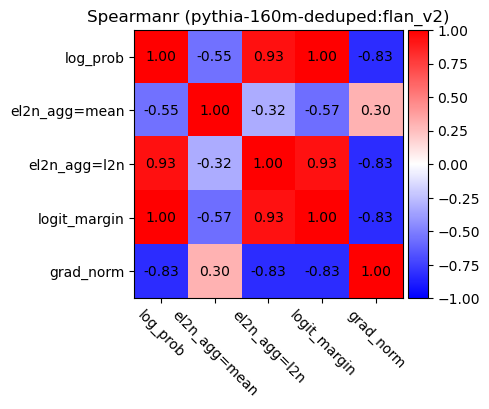

In [66]:
from rosemary import plt_kernel_matrix_one
import matplotlib.pyplot as plt
from scipy import stats

metrics_name = ['log_prob', 'el2n_agg=mean', 'el2n_agg=l2n', 'logit_margin', 'grad_norm']
metrics = [output[k] for k in metrics_name]
any_isnan_mask = np.hstack([np.isnan(x) for x in metrics]).any(-1)
metrics = [x[~any_isnan_mask] for x in metrics]
N = len(metrics)
K = np.zeros((N, N))
for i, mi in enumerate(metrics):
    for j, mj in enumerate(metrics):
        s = stats.spearmanr(mi, mj)
        K[i,j] = s.statistic
        

fig, ax = plt.subplots(1,1,figsize=(5,5))
plt_kernel_matrix_one(
    fig, ax, K, title=f'Spearmanr ({model_name}:{dataset})', 
    vmin=-1, vmax=1, cmap='bwr', annotate=True)
ax.set_xticklabels(metrics_name, rotation=-45)
ax.set_yticklabels(metrics_name)

fig.tight_layout()

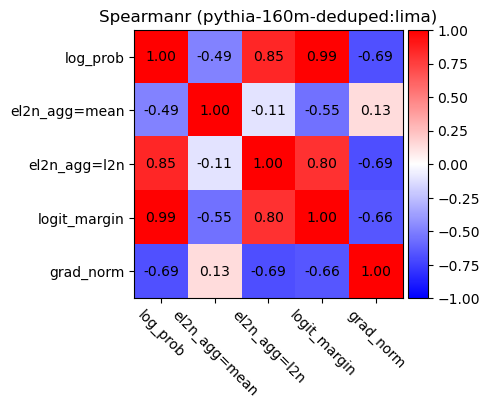

In [53]:
from rosemary import plt_kernel_matrix_one
import matplotlib.pyplot as plt
from scipy import stats

metrics_name = ['log_prob', 'el2n_agg=mean', 'el2n_agg=l2n', 'logit_margin', 'grad_norm']
metrics = [output[k] for k in metrics_name]
N = len(metrics)
K = np.zeros((N, N))
for i, mi in enumerate(metrics):
    for j, mj in enumerate(metrics):
        s = stats.spearmanr(mi, mj)
        K[i,j] = s.statistic
        

fig, ax = plt.subplots(1,1,figsize=(5,5))
plt_kernel_matrix_one(
    fig, ax, K, title=f'Spearmanr ({model_name}:{dataset})', 
    vmin=-1, vmax=1, cmap='bwr', annotate=True)
ax.set_xticklabels(metrics_name, rotation=-45)
ax.set_yticklabels(metrics_name)

fig.tight_layout()

In [11]:


outputs['loss'].backward()
# logits[0, class_idx].backward(retain_graph=True)

# bsz, seq, dim
# outputs['logits'][0,0,1000].backward(retain_graph=True)




In [12]:


grads = []

for param_name, param in model.named_parameters():
    if param.requires_grad and param.grad is not None:
        print(f"Gradient for {param_name}: {param.grad.shape}")
        grads.append(param.grad.squeeze())


Gradient for gpt_neox.embed_in.weight: torch.Size([50304, 768])
Gradient for gpt_neox.layers.0.input_layernorm.weight: torch.Size([768])
Gradient for gpt_neox.layers.0.input_layernorm.bias: torch.Size([768])
Gradient for gpt_neox.layers.0.post_attention_layernorm.weight: torch.Size([768])
Gradient for gpt_neox.layers.0.post_attention_layernorm.bias: torch.Size([768])
Gradient for gpt_neox.layers.0.attention.query_key_value.weight: torch.Size([2304, 768])
Gradient for gpt_neox.layers.0.attention.query_key_value.bias: torch.Size([2304])
Gradient for gpt_neox.layers.0.attention.dense.weight: torch.Size([768, 768])
Gradient for gpt_neox.layers.0.attention.dense.bias: torch.Size([768])
Gradient for gpt_neox.layers.0.mlp.dense_h_to_4h.weight: torch.Size([3072, 768])
Gradient for gpt_neox.layers.0.mlp.dense_h_to_4h.bias: torch.Size([3072])
Gradient for gpt_neox.layers.0.mlp.dense_4h_to_h.weight: torch.Size([768, 3072])
Gradient for gpt_neox.layers.0.mlp.dense_4h_to_h.bias: torch.Size([768])
G

In [13]:
grads = [x.reshape(-1,1) for x in grads]
grads = torch.vstack(grads)
grads.shape, torch.sum(grads*grads)

(torch.Size([162322944, 1]),
 tensor(1742., device='cuda:0', dtype=torch.float16))

In [15]:
print(f'grad = {grads.shape[0]*4/1024/1024/1024:.3f} GB')

grad = 0.605 GB


In [ ]:

# Compute gradients for all logits at once
class_indices = torch.arange(logits_all_classes.size(1))  # Assuming logits are in the second dimension
logit_gradients = torch.autograd.grad(outputs=logits_all_classes[:, class_indices], inputs=model.parameters(), retain_graph=True)


In [ ]:
from note_llama_embeddings import compute_losses

labels = batch['labels']
logits = outputs['logits']


# compute_losses(logits, labels)